PYTORCH로 딥러닝하기 60분만에 끝장내기

PyTorch 는 여러분이 신경망(neural network)를 생성하고 학습시키는 것을 도와주기 위해서 torch.nn , torch.optim , Dataset , 그리고 DataLoader 와 같은 잘 디자인된 모듈과 클래스들을 제공합니다. 이들의 성능을 최대한 활용하고 여러분의 문제에 맞게 커스터마이즈하기 위해서, 정확히 이들이 어떤 작업을 수행하는지 이해할 필요가 있습니다. 이해를 증진하기 위해서, 우리는 먼저 이들 모델들로 부터 아무 피쳐도 사용하지 않고 MNIST 데이터셋에 대해 기초적인 신경망을 학습시킬 것입니다; 우리는 처음에는 가장 기초적인 PyTorch 텐서(tensor) 기능만을 사용할 것입니다. 그리고나서 우리는 점차적으로 torch.nn, torch.optim, Dataset, 또는 DataLoader 로부터 한번에 하나씩 피쳐를 추가하면서, 정확히 각 부분이 어떤 일을 하는지 그리고 이것이 어떻게 코드를 더 간결하고 유연하게 만드는지 보여줄 것입니다.

이 튜토리얼은 여러분이 이미 PyTorch를 설치하였고, 그리고 텐서 연산의 기초에 대해 익숙하다고 가정합니다. (만약 여러분이 Numpy 배열(array) 연산에 익숙하다면, 여기에서 사용되는 PyTorch 텐서 연산도 거의 동일하다는 것을 알게 될 것입니다).

# MNIST 데이터 준비

In [10]:
from pathlib import Path
import requests
import pickle
import gzip
from matplotlib import pyplot
import numpy as np
import torch

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]  = "0"

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

In [3]:
URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [5]:
# 이 데이터셋은 numpy 배열 포맷이고, 데이터를 직렬화하기 위한 python 전용 포맷 pickle 을 이용하여 저장되어 있습니다.

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

torch.Size([50000, 784])


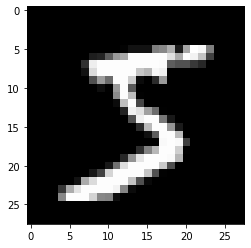

In [57]:
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [58]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [60]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [62]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [63]:
bs = 64  # 배치 크기

xb = x_train[0:bs]  # x로부터 미니배치(mini-batch) 추출
preds = model(xb)  # 예측
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.5157, -2.5862, -2.2571, -2.1425, -1.7519, -2.1675, -2.9518, -2.5488,
        -2.6556, -2.0153], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [64]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [65]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.2234, grad_fn=<NegBackward>)


In [66]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [67]:
print(accuracy(preds, yb))

tensor(0.1406)


In [68]:
from IPython.core.debugger import set_trace

lr = 0.5  # 학습률(learning rate)
epochs = 2  # 훈련에 사용할 에폭(epoch) 수

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [69]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0833, grad_fn=<NegBackward>) tensor(1.)


torch.nn.functional 사용하기

In [70]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [71]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0833, grad_fn=<NllLossBackward>) tensor(1.)


nn.Module 을 이용하여 리팩토링 하기

In [72]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [73]:
model = Mnist_Logistic()

In [81]:
print(loss_func(model(xb), yb))

tensor(2.2981, grad_fn=<NllLossBackward>)


In [80]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

In [ ]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

In [82]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [83]:
print(loss_func(model(xb), yb))

tensor(0.0801, grad_fn=<NllLossBackward>)


nn.Linear 를 이용하여 리팩토링 하기

In [84]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    def forward(self, xb):
        return self.lin(xb)

In [85]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2624, grad_fn=<NllLossBackward>)


In [86]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0810, grad_fn=<NllLossBackward>)


optim 을 이용하여 리팩토링 하기

In [87]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

In [ ]:
opt.step()
opt.zero_grad()

In [89]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr = lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3077, grad_fn=<NllLossBackward>)
tensor(0.0823, grad_fn=<NllLossBackward>)


Dataset 을 이용하여 리팩토링하기

In [90]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

In [91]:
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

In [92]:
xb,yb = train_ds[i*bs : i*bs+bs]

In [93]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward>)


DataLoader 를 이용하여 리팩토링하기

In [94]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [95]:
# 루프가 다음과 같이 배치 (xb, yb)를 반복했습니다:
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)

In [96]:
# (xb, yb)가 DataLoader 에서 자동으로 로드되므로 루프가 훨씬 깨끗해졌습니다:
for xb,yb in train_dl:
    pred = model(xb)

In [97]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0820, grad_fn=<NllLossBackward>)


검증(validation) 추가하기

In [98]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [99]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        # 역전파 단계를 수행하고, 가중치를 갱신합니다. 변화도를 0으로 만들고
        loss.backward() 
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3107)
1 tensor(0.2772)


fit() 와 get_data() 생성하기

In [100]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [101]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [102]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [103]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33189625689983365
1 0.38568839030265806


CNN 으로 넘어가기

In [104]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [105]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3412387899398804
1 0.24129538984298707


nn.Sequential

In [106]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [107]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.37373606543540955
1 0.23463422741889953


DataLoader 감싸기

In [108]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            # yield 키워드는 Python에서 생성기 함수를 정의하는 데 사용되는 Python 문입니다. 
            # yield 문은 함수 본문 내에서만 사용할 수 있습니다. 
            yield (self.func(*b)) 

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)